In [1]:
from SafeTransformer import SafeTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from copy import deepcopy
from math import floor, fmod, log
from scipy.special import logit
from sklearn import metrics
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
def y_function(value1, value2):
    if value1 < -3:
        if value2  <= 3:
            return 0
        else:
            return 1
    if value1 < 2.5:
        if value2 >= 2:
            return 1
        else:
            return 0
    if value2 < 4:
        return 0
    else:
        return 1

In [3]:
n = 500

In [4]:
np.random.seed(123)
X2_orig = np.random.uniform(low=0, high=40, size=n)

X2_factors_40 = []
for i in range(n):
    X2_factors_40.append(floor(X2_orig[i]))

    X2_factors_5 = []
for i in range(n):
    X2_factors_5.append(fmod(X2_factors_40[i], 5))

In [5]:
np.random.seed(123)
X_Artif = pd.DataFrame(data={
    'X1': np.linspace(-5, 5, n),
    'X2': X2_factors_40})
y = pd.Series(map(lambda value: y_function(value[0], value[1]), zip(X_Artif['X1'], X2_factors_5
                                                                   )))


In [6]:
X_Artif['X1'] = X_Artif['X1'] + np.random.normal(size=n, scale=0.13)
X_Artif['X2'] = 'A' + X_Artif['X2'].astype(str)
X_Artif['X2'] = X_Artif['X2'].astype('category')
X_Artif.head()

,X1,X2
0,-5.141132,A27
1,-4.850305,A11
2,-4.923133,A9
3,-5.135698,A22
4,-4.995058,A28


In [7]:
X_Artif.dtypes

X1     float64
X2    category
dtype: object

In [8]:
X = X_Artif.copy()
colnames = list(X)
for idx, name in enumerate(colnames):
    if str(X.loc[:, name].dtype) in ['category', 'object']:
        dummies = pd.get_dummies(X.loc[:, name], prefix=name, drop_first=True)
        dummy_index  = X.columns.get_loc(name)
        X = pd.concat([X.iloc[:,range(dummy_index)], dummies, X.iloc[:, range(dummy_index+1, len(X.columns))]], axis=1)

In [9]:
X_train, X_test, X_lin_train, X_lin_test, y_train, y_test = train_test_split(X_Artif, X, y, random_state = 123)

In [10]:
logistic_model = LogisticRegression(solver = 'lbfgs')
logistic_model = logistic_model.fit(X_lin_train, y_train)
standard_predictions = logistic_model.predict(X_lin_test)
print(accuracy_score(y_test, standard_predictions))

pred = logistic_model.predict_proba(X_lin_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.736


0.8968253968253967

In [11]:
surrogate_model = GradientBoostingClassifier(random_state = 123)
surrogate_model = surrogate_model.fit(X_lin_train, y_train)
surrogate_model_predictions = surrogate_model.predict(X_lin_test)
print(accuracy_score(y_test, surrogate_model_predictions))

pred = surrogate_model.predict_proba(X_lin_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.96


0.9824628776241678

In [12]:
pens = np.linspace(0.01, 10, 25)
best_auc = float('-Inf')
best_acc = float('-Inf')
best_auc_pen = 0
best_acc_pen = 0
aucs = []
accs = []

for pen in pens:
    surrogate_model = GradientBoostingClassifier(random_state = 123)
    logistic_model_simple = LogisticRegression(solver = 'lbfgs')
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)
    pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', logistic_model_simple)])
    pipe = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    accs.append(acc)
    
    pred = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    
    print([pen, acc, auc])
    if acc > best_acc:
        best_acc_transformer = deepcopy(safe_transformer)
        best_acc_model = deepcopy(logistic_model_simple)
        best_acc = acc
        best_acc_pen = pen
        
    if auc > best_auc:
        best_auc_transformer = deepcopy(safe_transformer)
        best_auc_model = deepcopy(logistic_model_simple)
        best_auc = auc
        best_auc_pen = pen

[0.01, 0.976, 0.9891193036354327]
[0.42625, 0.976, 0.989247311827957]
[0.8425, 0.976, 0.989247311827957]
[1.25875, 0.976, 0.989247311827957]
[1.675, 0.976, 0.989247311827957]
[2.0912499999999996, 0.976, 0.989247311827957]
[2.5075, 0.976, 0.989247311827957]
[2.92375, 0.976, 0.989247311827957]
[3.34, 0.976, 0.989247311827957]
[3.7562499999999996, 0.976, 0.989247311827957]
[4.172499999999999, 0.976, 0.989247311827957]
[4.58875, 0.976, 0.989247311827957]
[5.005, 0.976, 0.989247311827957]
[5.42125, 0.976, 0.989247311827957]
[5.8375, 0.976, 0.989247311827957]
[6.25375, 0.976, 0.989247311827957]
[6.67, 0.976, 0.989247311827957]
[7.08625, 0.976, 0.989247311827957]
[7.5024999999999995, 0.976, 0.989247311827957]
[7.91875, 0.976, 0.989247311827957]
[8.334999999999999, 0.976, 0.989247311827957]
[8.75125, 0.976, 0.989247311827957]
[9.1675, 0.976, 0.989247311827957]
[9.58375, 0.976, 0.989247311827957]
[10.0, 0.976, 0.989247311827957]


In [13]:
best_auc

0.989247311827957

In [14]:
best_acc

0.976

In [15]:
best_auc_pen

0.42625

In [16]:
best_acc_pen

0.01

/home/alicja/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


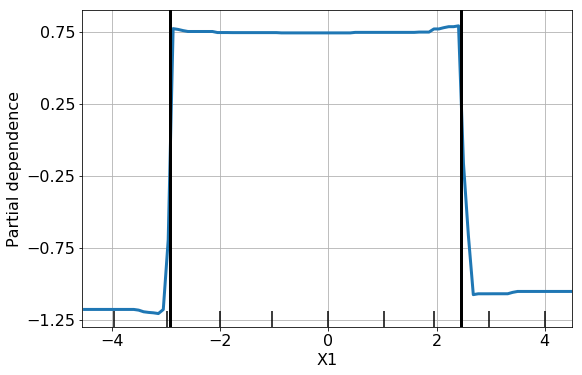

In [17]:
plt.rcParams["figure.figsize"] = [8, 8]
f, axis = plot_partial_dependence(surrogate_model, X, [0],
                                 line_kw = {"linewidth": 3}) 
plt.axvline(-2.93, c = "black", linewidth=3.0)
plt.axvline(2.46, c = "black",  linewidth=3.0)
plt.ylim(-1.3, 0.9)
plt.xlim(-4.55, 4.5)
plt.xlabel('X1')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Partial dependence", fontsize=16)
plt.xlabel("X1", fontsize=16)
ax = f.add_subplot(1, 1, 1)
ax.set_yticks(np.arange(-1.25, 1, 0.5))

f.savefig("clasification_PDP_X2.pdf", bbox_inches='tight')

In [18]:
best_auc_transformer.summary()

Numerical Variable X1
Selected intervals:
	[-Inf, -2.93)
	[-2.93, 2.46)
	[2.46, Inf)
Categorical Variable X2
Created variable levels:
	A0, A12, A13, A17, A18, A2, A22, A23, A27, A28, A3, A32, A33, A37, A38, A7, A8 -> A0_A12_A13_A17_A18_A2_A22_A23_A27_A28_A3_A32_A33_A37_A38_A7_A8
	A1, A10, A11, A15, A16, A20, A21, A25, A26, A30, A31, A35, A36, A5, A6 -> A1_A10_A11_A15_A16_A20_A21_A25_A26_A30_A31_A35_A36_A5_A6
	A14, A19, A24, A29, A34, A39, A4, A9 -> A14_A19_A24_A29_A34_A39_A4_A9

